# Imports

In [1]:
import pathlib
import warnings

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import (
    temporal_train_test_split,
    ForecastingGridSearchCV,
    SlidingWindowSplitter
)
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS
from sktime.performance_metrics.forecasting import sMAPE, smape_loss

In [4]:
warnings.filterwarnings("ignore")

# Data

In [5]:
y = load_airline()

In [6]:
y.head()

Period
1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
Freq: M, Name: Number of airline passengers, dtype: float64

# Split

In [7]:
test_size = 12
fh = np.arange(test_size) + 1

In [8]:
y_train, y_test = temporal_train_test_split(y, fh=fh)

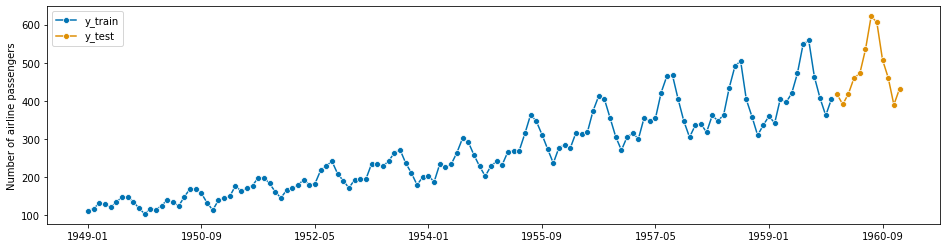

In [9]:
plot_series(y_train, y_test, labels=['y_train', 'y_test'])
plt.show()

# Splitter

In [10]:
# Multi-step forecasting horizons with multiple cutoffs/windows are not supported by sktime v0.5.3
cv = SlidingWindowSplitter(
    fh=fh[-1],
    initial_window=len(y_train) // 2
)

# Simple Exponential Smoothing

In [11]:
ses_param_grid = {}

In [12]:
%%time
ses_cv = ForecastingGridSearchCV(
    forecaster=ExponentialSmoothing(), 
    cv=cv, 
    param_grid=ses_param_grid,
    scoring=sMAPE()
)
ses_cv.fit(y_train)

CPU times: user 1.42 s, sys: 16.7 ms, total: 1.44 s
Wall time: 1.42 s


ForecastingGridSearchCV(cv=<sktime.forecasting.model_selection._split.SlidingWindowSplitter object at 0x7fa17cbd9d30>,
                        forecaster=ExponentialSmoothing(), param_grid={},
                        scoring=<sktime.performance_metrics.forecasting._classes.sMAPE object at 0x7fa17ca16a30>)

In [13]:
ses_result_df = pd.DataFrame(ses_cv.cv_results_)
ses_result_df

,mean_fit_time,mean_score_time,params,mean_test_sMAPE,rank_test_sMAPE
0,0.03837,1.359599,{},0.311732,1


In [14]:
y_pred = ses_cv.predict(fh)
smape_loss(y_test, y_pred)

0.16155480390887259

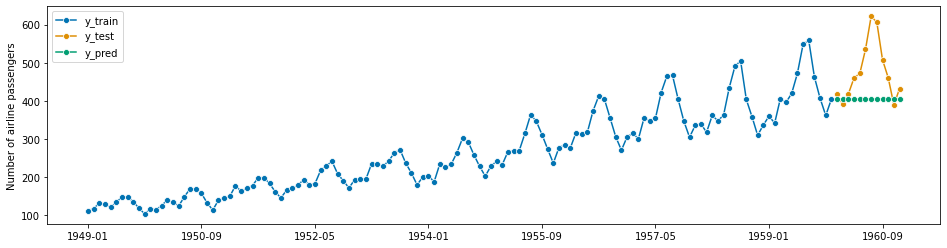

In [15]:
plot_series(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])
plt.show()

# Double Exponential Smoothing

DES Parameters:
- trend : str{"add", "mul", "additive", "multiplicative", None}, optional (default=None)
    - Type of trend component.
- damped_trend : bool, optional (default=None)
    - Should the trend component be damped.
- use_boxcox - {True, False, 'log', float}, optional
    - Should the Box-Cox transform be applied to the data first? If 'log' then apply the log. If float then use lambda equal to float.

In [16]:
des_param_grid = {
    'trend': ['add', 'mul'],
    'damped_trend': [False, True],
    'use_boxcox': [False, True, 0]
}

In [17]:
%%time
des_cv = ForecastingGridSearchCV(
    forecaster=ExponentialSmoothing(), 
    cv=cv, 
    param_grid=des_param_grid,
    scoring=sMAPE(),
    n_jobs=-1
)
des_cv.fit(y_train)

CPU times: user 23.8 s, sys: 58.6 ms, total: 23.8 s
Wall time: 23.8 s


ForecastingGridSearchCV(cv=<sktime.forecasting.model_selection._split.SlidingWindowSplitter object at 0x7fa17cbd9d30>,
                        forecaster=ExponentialSmoothing(), n_jobs=-1,
                        param_grid={'damped_trend': [False, True],
                                    'trend': ['add', 'mul'],
                                    'use_boxcox': [False, True, 0]},
                        scoring=<sktime.performance_metrics.forecasting._classes.sMAPE object at 0x7fa17cb25e80>)

In [18]:
des_result_df = pd.DataFrame(des_cv.cv_results_)
des_result_df

,mean_fit_time,mean_score_time,param_damped_trend,param_trend,param_use_boxcox,params,mean_test_sMAPE,rank_test_sMAPE
0,0.121585,1.557957,False,add,False,"{'damped_trend': False, 'trend': 'add', 'use_b...",0.118206,1
1,0.136925,2.452722,False,add,True,"{'damped_trend': False, 'trend': 'add', 'use_b...",0.180057,5
2,0.103503,1.967340,False,add,0,"{'damped_trend': False, 'trend': 'add', 'use_b...",0.309891,8
3,0.561383,1.587686,False,mul,False,"{'damped_trend': False, 'trend': 'mul', 'use_b...",NaN,11
4,0.132159,1.992586,False,mul,True,"{'damped_trend': False, 'trend': 'mul', 'use_b...",0.204942,6
5,0.120608,1.591745,False,mul,0,"{'damped_trend': False, 'trend': 'mul', 'use_b...",0.225147,7
6,0.117258,1.532585,True,add,False,"{'damped_trend': True, 'trend': 'add', 'use_bo...",0.132583,3
7,0.133137,1.938617,True,add,True,"{'damped_trend': True, 'trend': 'add', 'use_bo...",0.128218,2
8,0.105116,1.527894,True,add,0,"{'damped_trend': True, 'trend': 'add', 'use_bo...",0.310351,9
9,0.632487,1.524850,True,mul,False,"{'damped_trend': True, 'trend': 'mul', 'use_bo...",NaN,12


In [19]:
des_cv.best_params_

{'damped_trend': False, 'trend': 'add', 'use_boxcox': False}

In [20]:
des_cv.best_score_

0.1182064986895786

In [21]:
y_pred = des_cv.predict(fh)
smape_loss(y_test, y_pred)

0.14023178895227412

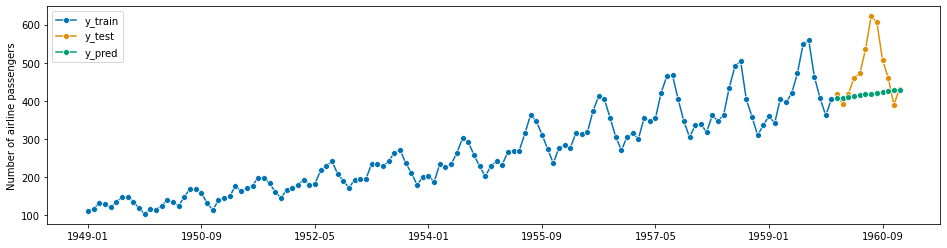

In [22]:
plot_series(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])
plt.show()

# Triple Exponential Smoothing

TES Parameters:
- trend : str{"add", "mul", "additive", "multiplicative", None}, optional (default=None)
    - Type of trend component.
- damped_trend : bool, optional (default=None)
    - Should the trend component be damped.
- seasonal : {"add", "mul", "additive", "multiplicative", None}, optional (default=None)
    - Type of seasonal component.
- sp : int, optional (default=None)
    - The number of seasonal periods to consider.
- use_boxcox - {True, False, 'log', float}, optional
    - Should the Box-Cox transform be applied to the data first? If 'log' then apply the log. If float then use lambda equal to float.

In [23]:
tes_param_grid = {
    'trend': ['add', 'mul'],
    'damped_trend': [False, True],
    'seasonal': ['add', 'mul'],
    'sp': [12],
    'use_boxcox': [False, True, 0]
}

In [24]:
%%time
tes_cv = ForecastingGridSearchCV(
    forecaster=ExponentialSmoothing(), 
    cv=cv, 
    param_grid=tes_param_grid,
    scoring=sMAPE(),
    n_jobs=-1
)
tes_cv.fit(y_train)

CPU times: user 1min 10s, sys: 120 ms, total: 1min 10s
Wall time: 1min 10s


ForecastingGridSearchCV(cv=<sktime.forecasting.model_selection._split.SlidingWindowSplitter object at 0x7fa17cbd9d30>,
                        forecaster=ExponentialSmoothing(), n_jobs=-1,
                        param_grid={'damped_trend': [False, True],
                                    'seasonal': ['add', 'mul'], 'sp': [12],
                                    'trend': ['add', 'mul'],
                                    'use_boxcox': [False, True, 0]},
                        scoring=<sktime.performance_metrics.forecasting._classes.sMAPE object at 0x7fa17c9758e0>)

In [25]:
tes_result_df = pd.DataFrame(tes_cv.cv_results_)
tes_result_df

,mean_fit_time,mean_score_time,param_damped_trend,param_seasonal,param_sp,param_trend,param_use_boxcox,params,mean_test_sMAPE,rank_test_sMAPE
0,0.693432,1.908475,False,add,12,add,False,"{'damped_trend': False, 'seasonal': 'add', 'sp...",0.139335,6
1,0.656871,2.028547,False,add,12,add,True,"{'damped_trend': False, 'seasonal': 'add', 'sp...",0.066239,1
2,0.637833,1.731358,False,add,12,add,0,"{'damped_trend': False, 'seasonal': 'add', 'sp...",0.364797,11
3,1.163908,1.883451,False,add,12,mul,False,"{'damped_trend': False, 'seasonal': 'add', 'sp...",0.103154,3
4,0.796481,2.085618,False,add,12,mul,True,"{'damped_trend': False, 'seasonal': 'add', 'sp...",0.066501,2
5,0.783622,1.625412,False,add,12,mul,0,"{'damped_trend': False, 'seasonal': 'add', 'sp...",0.292003,9
6,1.290144,1.666146,False,mul,12,add,False,"{'damped_trend': False, 'seasonal': 'mul', 'sp...",NaN,22
7,1.269016,2.122007,False,mul,12,add,True,"{'damped_trend': False, 'seasonal': 'mul', 'sp...",NaN,21
8,0.630914,1.667434,False,mul,12,add,0,"{'damped_trend': False, 'seasonal': 'mul', 'sp...",0.368618,12
9,1.448586,1.695921,False,mul,12,mul,False,"{'damped_trend': False, 'seasonal': 'mul', 'sp...",NaN,20


In [26]:
tes_cv.best_params_

{'damped_trend': False,
 'seasonal': 'add',
 'sp': 12,
 'trend': 'add',
 'use_boxcox': True}

In [27]:
tes_cv.best_score_

0.06623934183602245

In [28]:
y_pred = tes_cv.predict(fh)
smape_loss(y_test, y_pred)

0.036370766565920504

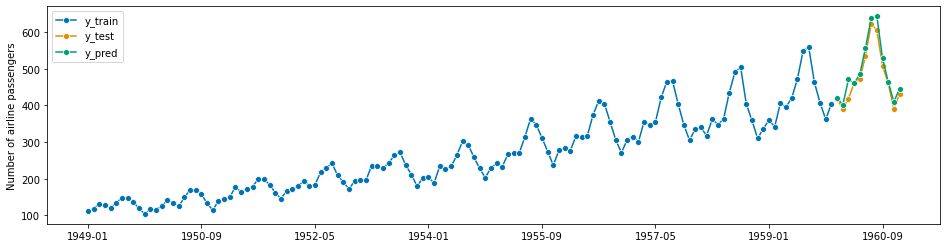

In [29]:
plot_series(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])
plt.show()

# Auto Exponential Smoothing

In [30]:
aes_param_grid = {
    'sp': [12]
}

In [31]:
%%time
aes_cv = ForecastingGridSearchCV(
    forecaster=AutoETS(auto=True, 
                       information_criterion='aicc', 
                       allow_multiplicative_trend=True, 
                       n_jobs=-1), 
    cv=cv, 
    param_grid=aes_param_grid,
    scoring=sMAPE(),
    n_jobs=-1
)
aes_cv.fit(y_train)

CPU times: user 2.79 s, sys: 233 ms, total: 3.02 s
Wall time: 21 s


ForecastingGridSearchCV(cv=<sktime.forecasting.model_selection._split.SlidingWindowSplitter object at 0x7fa17cbd9d30>,
                        forecaster=AutoETS(allow_multiplicative_trend=True,
                                           auto=True,
                                           information_criterion='aicc',
                                           n_jobs=-1),
                        n_jobs=-1, param_grid={'sp': [12]},
                        scoring=<sktime.performance_metrics.forecasting._classes.sMAPE object at 0x7fa17cbcfac0>)

In [32]:
aes_result_df = pd.DataFrame(aes_cv.cv_results_)
aes_result_df

,mean_fit_time,mean_score_time,param_sp,params,mean_test_sMAPE,rank_test_sMAPE
0,12.41902,1.947601,12,{'sp': 12},0.059557,1


In [33]:
aes_cv.best_params_

{'sp': 12}

In [34]:
aes_cv.best_score_

0.05955721229885578

In [35]:
y_pred = aes_cv.predict(fh)
smape_loss(y_test, y_pred)

0.041238573180010715

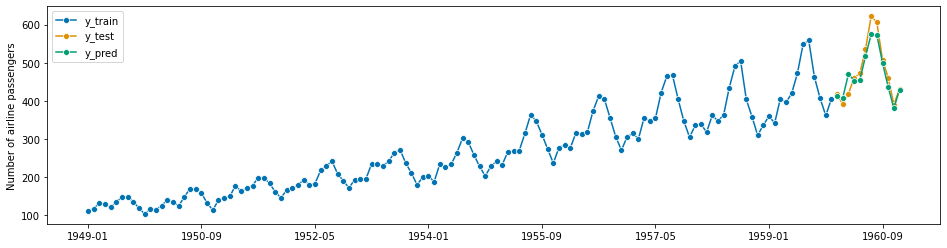

In [36]:
plot_series(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])
plt.show()